In [23]:
import pandas as pd
import numpy as np

# Custom functions
from my_functions import *

### Import data

In [2]:
# Box Office Mojo list
df_mojo = pd.read_csv('bk_mojo.csv', dtype = object)
df_mojo.head(2)

,Title,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
0,Avatar,"$2,847,246,203","$760,507,625",26.7%,"$2,086,738,578",73.3%,2009
1,Avengers: Endgame,"$2,797,501,328","$858,373,000",30.7%,"$1,939,128,328",69.3%,2019


In [3]:
# Google results
df_google = pd.read_csv('bk_google_mojo.csv', dtype = object)
df_google.head(2)

,Title,Year,google_use_like,google_use_score,google_use_n_rev,movie_description,imdb_score,rotten_tom_score,metacritic_score,id
0,Avatar,2009,0.86,0.9,4274.0,"Jake, who is paraplegic, replaces his twin on ...",0.78,0.81,0.83,Avatar-2009
1,Avengers: Endgame,2019,0.94,0.9400000000000001,22212.0,"After Thanos, an intergalactic warlord, disint...",0.8400000000000001,0.94,NaN,Avengers: Endgame-2019


In [4]:
# Rotten Tomatoes
df_rt = pd.concat([pd.read_csv('bk_rt_1_raw.csv', dtype = object)
                   , pd.read_csv('bk_rt_2_raw.csv', dtype = object)
                   , pd.read_csv('bk_rt_3_raw.csv', dtype = object)
                   , pd.read_csv('bk_rt_4_raw.csv', dtype = object)])
df_rt.head(2)

,review,mojo_name,mojo_year,rt_name,genre,release_year,stream_year
0,Five hundred million dollars [wasted].,Avatar,2009,Avatar - Movie Reviews,"Fantasy , Action , Adventure , Sci-Fi",2009,2016
1,"Rewatching it with fresh eyes 10 years later, ...",Avatar,2009,Avatar - Movie Reviews,"Fantasy , Action , Adventure , Sci-Fi",2009,2016


In [5]:
# Remove Rotten Tomato records without reviews
df_rt_clean = df_rt.loc[~((df_rt['review'] == 'no reviews found')
                          |
                          (df_rt['review'] == 'misc error')
                          |
                          (df_rt['review'] == '')
                         )
                        ,:].dropna()

# Remove records where release year != mojo_year
df_rt_clean = df_rt_clean[df_rt_clean['mojo_year'] == df_rt_clean['release_year']]

# Group records into a single line per film (reviews become a list of reviews)
df_rt_clean = rev_group_list(df_rt_clean, 'review', 'mojo_name')

print('Number of records remaining: ', len(df_rt_clean))

df_rt_clean.to_csv('test.csv', index = False)

df_rt_clean.head()

Number of records remaining:  669


,review,mojo_name,mojo_year,rt_name,genre,release_year,stream_year
1112,[ ‘Here are beauties that pierce like swords o...,The Lord of the Rings: The Fellowship of the Ring,2001,The Lord of the Rings: The Fellowship of the R...,"Fantasy , Adventure",2001,2011
391,"[""...for me to consider Captain America: Civil...",Captain America: Civil War,2016,Captain America: Civil War - Movie Reviews,"Action , Adventure , Fantasy",2016,2016
1477,"[""21 Jump Street"" might be yet another product...",21 Jump Street,2012,21 Jump Street - Movie Reviews,"Comedy , Action",2012,2014
2910,"[""300: Rise of an Empire"" gets a lot of mileag...",300: Rise of an Empire,2014,300: Rise of an Empire - Movie Reviews,"Action , Adventure , Drama",2014,2015
1140,"[""A Dog's Purpose"" left me cherishing my borde...",A Dog's Purpose,2017,A Dog's Purpose - Movie Reviews,"Fantasy , Drama , Comedy",2017,2017


### Merge DataFrames

In [6]:
# Merge Mojo and Google data
df_mojo_goo = df_mojo.merge(df_google
                           , on = ['Title', 'Year'])

print('All rows joined?', 1000 == len(df_mojo_goo))

All rows joined? True


In [77]:
# Merge Rotten Tomatoes data
df_merge = df_mojo_goo.merge(df_rt_clean
                             , left_on = ['Title', 'Year']
                             , right_on = ['mojo_name', 'mojo_year'])

# Filter to columns that we will need
df_merge = df_merge.loc[:,['Title'
                          , 'Year'
                          , 'Worldwide Lifetime Gross'
                          , 'Domestic %'
                          , 'google_use_like'
                          , 'google_use_score'
                          , 'google_use_n_rev'
                          , 'imdb_score'
                          , 'rotten_tom_score'
                          , 'genre'
                          , 'movie_description'
                          , 'review']]

# Rename columns
df_merge.columns = ['title'
                  , 'year'
                  , 'worldwide_gross'
                  , 'usa_percent'
                  , 'google_use_like'
                  , 'google_score'
                  , 'google_use_n_rev'
                  , 'imdb_score'
                  , 'rotten_tom_score'
                  , 'genre'
                  , 'movie_description'
                  , 'review']

# Remove any empty rows remaining
df_merge = df_merge.dropna()

print('Number of records remaining: ', len(df_merge))

Number of records remaining:  630


### Clean up DataFrame

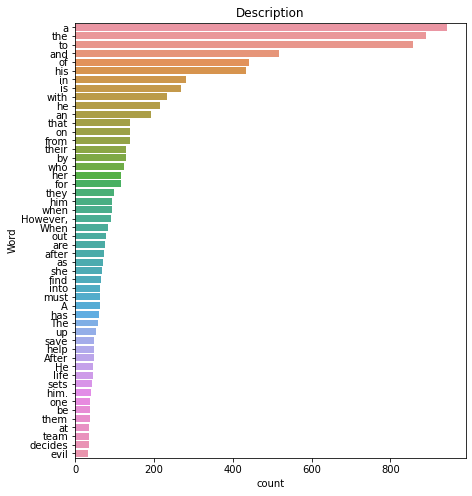

In [71]:
freq_words_chart(df_merge['movie_description'], 50, 'Description')

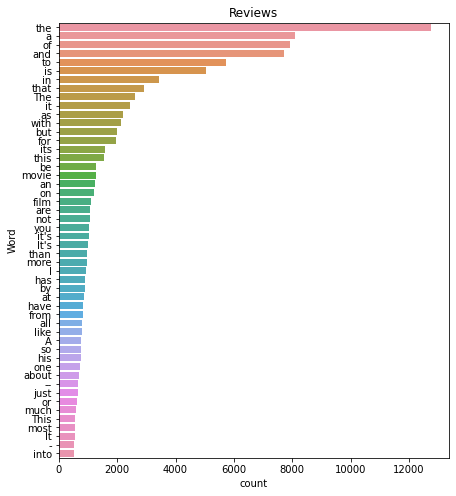

In [72]:
freq_words_chart(df_merge['review'].apply(lambda x: ', '.join(x)), 50, 'Reviews')

In [78]:
# Convert numbers to floats
df_merge['worldwide_gross'] = df_merge['worldwide_gross'].apply(lambda x: re.sub("[^0-9]", "",x)).astype(float)
df_merge['usa_percent'] = df_merge['usa_percent'].apply(lambda x: usa_pc(x))
df_merge['google_use_like'] = df_merge['google_use_like'].astype(float)
df_merge['google_score'] = df_merge['google_score'].astype(float)
df_merge['google_use_n_rev'] = df_merge['google_use_n_rev'].astype(float)
df_merge['imdb_score'] = df_merge['imdb_score'].astype(float)
df_merge['rotten_tom_score'] = df_merge['rotten_tom_score'].astype(float)

# Clean text
# 1) Remove non-letters
# 2) Remove stop words for descriptions and reviews
# 3) Lemmatize text for descriptions and reviews
df_merge['genre'] = df_merge['genre'].apply(lambda x: re.sub(" ,",",", x).lower())   
df_merge['movie_description'] = df_merge['movie_description'].apply(lambda x: clean_text(x, True))    
df_merge['review_list'] = df_merge['review'].apply(lambda x: clean_text_list(x, True)) 
df_merge['reviews'] = df_merge['review_list'].apply(lambda x: ', '.join(x))

df_merge.head(3)

,title,year,worldwide_gross,usa_percent,google_use_like,google_score,google_use_n_rev,imdb_score,rotten_tom_score,genre,movie_description,review,review_list,reviews
0,Avatar,2009,2.847246e+09,0.267,0.86,0.90,4274.0,0.78,0.81,"fantasy, action, adventure, sci-fi",jake paraplegic replaces twin navi inhabited p...,[Avatar is a joyous celebration of story craft...,[avatar joyous celebration story craft visual ...,avatar joyous celebration story craft visual p...
1,Avengers: Endgame,2019,2.797501e+09,0.307,0.94,0.94,22212.0,0.84,0.94,"action, adventure, sci-fi, fantasy",thanos intergalactic warlord disintegrates hal...,"[...A wonderful, rousing payoff in the context...",[wonderful rousing payoff context big battle w...,wonderful rousing payoff context big battle wi...
2,Titanic,1997,2.201647e+09,0.300,0.94,0.94,8466.0,0.78,0.89,"romance, history, drama",seventeen year old rose hails aristocratic fam...,"[""Titanic"" still amazes as the kind of massive...",[titanic still amazes kind massive build destr...,titanic still amazes kind massive build destro...


In [9]:
df_merge.to_csv('test.csv', index = False)

### Exploratory Data Analysis

#### Evaluate most frequent words
It appears the words 'however', and 'must' are the most and forth most frequent words in the description field. This words do not add any meaning and could be removed from the corpus. 

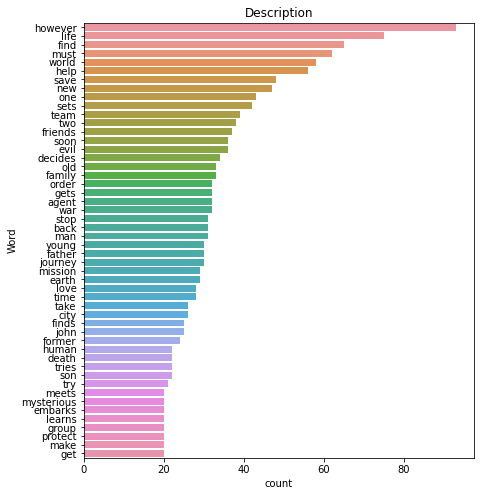

In [83]:
freq_words_chart(df_merge['movie_description'], 50, 'Description')

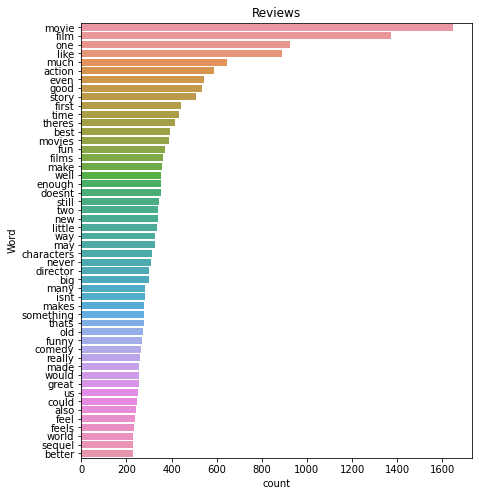

In [79]:
freq_words_chart(df_merge['reviews'], 50, 'Reviews')

## Sentiment Analysis

In [85]:
# Scoring, see (Hutto, n.d.)

# Determine Sentiment of Reviews
df_merge['sentiment'] = df_merge['review'].apply(lambda x: sid_analyser(x, True))
df_merge['sentiment_all'] = df_merge['review'].apply(lambda x: sid_analyser(x, False))

# Split overall scores into seperate columns for plotting
df_merge['sentiment_pos'] = df_merge['sentiment'].apply(lambda x: x['pos'])
df_merge['sentiment_neg'] = df_merge['sentiment'].apply(lambda x: x['neg'])
df_merge['sentiment_neu'] = df_merge['sentiment'].apply(lambda x: x['neu'])
df_merge['sentiment_comp'] = df_merge['sentiment'].apply(lambda x: x['compound'])

# Apply overall sentiment classification label
df_merge['sentiment_overall'] = df_merge['sentiment'].apply(lambda x: sentiment_overall(x['compound']))

df_merge.head(2)

,title,year,worldwide_gross,usa_percent,google_use_like,google_score,google_use_n_rev,imdb_score,rotten_tom_score,genre,...,review,review_list,reviews,sentiment,sentiment_all,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_comp,sentiment_overall
0,Avatar,2009,2.847246e+09,0.267,0.86,0.90,4274.0,0.78,0.81,"fantasy, action, adventure, sci-fi",...,[Avatar is a joyous celebration of story craft...,[avatar joyous celebration story craft visual ...,avatar joyous celebration story craft visual p...,"{'neg': 0.039, 'neu': 0.784, 'pos': 0.177, 'co...","[{'neg': 0.046, 'neu': 0.814, 'pos': 0.14, 'co...",0.177,0.039,0.784,0.9968,positive
1,Avengers: Endgame,2019,2.797501e+09,0.307,0.94,0.94,22212.0,0.84,0.94,"action, adventure, sci-fi, fantasy",...,"[...A wonderful, rousing payoff in the context...",[wonderful rousing payoff context big battle w...,wonderful rousing payoff context big battle wi...,"{'neg': 0.044, 'neu': 0.822, 'pos': 0.134, 'co...","[{'neg': 0.118, 'neu': 0.588, 'pos': 0.294, 'c...",0.134,0.044,0.822,0.9910,positive


In [86]:
df_merge['sentiment_overall'].value_counts()

positive    557
negative     72
neutral       1
Name: sentiment_overall, dtype: int64

Text(0.5, 1.0, 'Compound Sentiment')

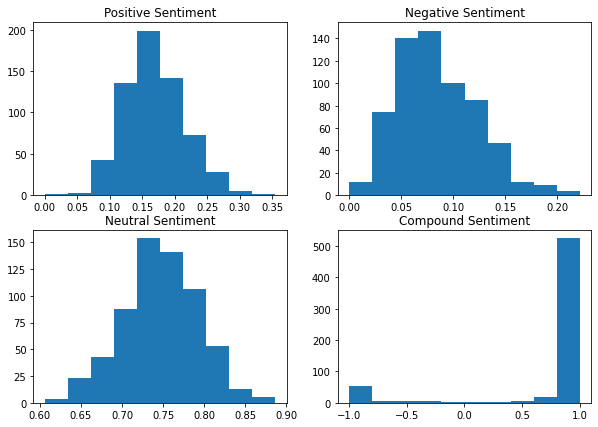

In [88]:

fig, axs = plt.subplots(2, 2, figsize = (10,7))

# Distribution of words chart
axs[0,0].hist(df_merge['sentiment_pos'])
axs[0,0].set_title("Positive Sentiment")
axs[0,1].hist(df_merge['sentiment_neg'])
axs[0,1].set_title("Negative Sentiment")
axs[1,0].hist(df_merge['sentiment_neu'])
axs[1,0].set_title("Neutral Sentiment")
axs[1,1].hist(df_merge['sentiment_comp'])
axs[1,1].set_title("Compound Sentiment")